In [ ]:
import pandas as pd

# Load the datasets
pre_pandemic = pd.read_csv('data_files/pre_pandemic.csv')
pandemic = pd.read_csv('data_files/pandemic.csv')
post_pandemic = pd.read_csv('data_files/post_pandemic.csv')


post_pandemic.rename(columns={'AVAILABLE_BIKE_STANDS':'AVAILABLE BIKE STANDS',
                        'AVAILABLE_BIKES': 'AVAILABLE BIKES'}, inplace=True)


for df in [pre_pandemic, pandemic, post_pandemic]:
    df['TIME'] = pd.to_datetime(df['TIME'])


def calculate_bike_usage(df):
    df = df.sort_values(['STATION ID', 'TIME'])
    df['BIKE_USAGE'] = df.groupby('STATION ID')['AVAILABLE BIKES'].diff().abs()
    df['BIKE_USAGE'] = df['BIKE_USAGE'].fillna(0)
    return df

pre_pandemic = calculate_bike_usage(pre_pandemic)
pandemic = calculate_bike_usage(pandemic)
post_pandemic = calculate_bike_usage(post_pandemic)


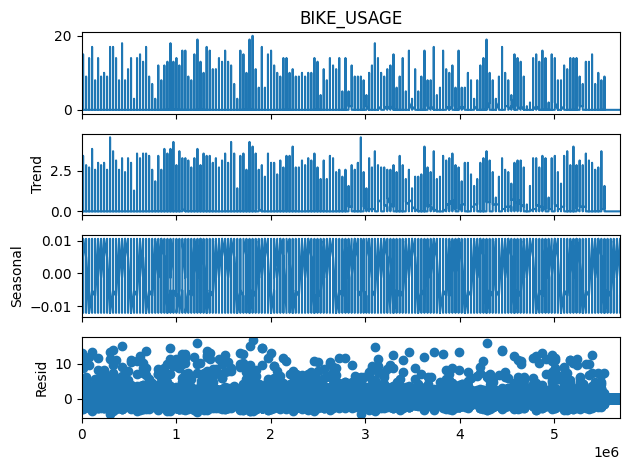

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


station_id = pre_pandemic['STATION ID'].iloc[0]
station_data = pre_pandemic[pre_pandemic['STATION ID'] == station_id]


decomposition = seasonal_decompose(station_data['BIKE_USAGE'], model='additive', period=7)
decomposition.plot()
plt.show()



In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 7


sarima_model = SARIMAX(station_data['BIKE_USAGE'],
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, s),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()


print(sarima_result.summary())


/Users/namanarora/Documents/TCD/ML/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/namanarora/Documents/TCD/ML/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78573D+00    |proj g|=  2.30787D-01


 This problem is unconstrained.



At iterate    5    f=  1.57715D+00    |proj g|=  2.99438D-01

At iterate   10    f=  1.56565D+00    |proj g|=  1.59918D-01

At iterate   15    f=  1.56545D+00    |proj g|=  2.70731D-02

At iterate   20    f=  1.56545D+00    |proj g|=  5.42303D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     46      1     0     0   5.420D-04   1.565D+00
  F =   1.5654485351838321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                     SARIMAX Results                                     
Dep. Variable:                        BIKE_USAGE   No. Observations:                50410
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -78914.261
Date:                           Sun, 07 Jan 2024   AIC                         157838.521
Time:                                   10:15:46   BIC                         157882.659
Sample:                                        0   HQIC                        157852.342
                                         - 50410                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0741      0.003     25.987      0.000       0.069       0.080
ma.L1         -1.0751      0.002   -632.404

In [ ]:

pandemic_forecast = sarima_result.get_forecast(steps=len(pandemic['TIME'].unique()))
pandemic_forecast_ci = pandemic_forecast.conf_int()


post_pandemic_forecast = sarima_result.get_forecast(steps=len(post_pandemic['TIME'].unique()))
post_pandemic_forecast_ci = post_pandemic_forecast.conf_int()


/Users/namanarora/Documents/TCD/ML/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/namanarora/Documents/TCD/ML/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/namanarora/Documents/TCD/ML/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:

actual_pandemic_usage = pandemic[pandemic['STATION ID'] == station_id]['BIKE_USAGE'].sum()
predicted_pandemic_usage = pandemic_forecast.predicted_mean.sum()
impact_during_pandemic = actual_pandemic_usage - predicted_pandemic_usage

actual_post_pandemic_usage = post_pandemic[post_pandemic['STATION ID'] == station_id]['BIKE_USAGE'].sum()
predicted_post_pandemic_usage = post_pandemic_forecast.predicted_mean.sum()
impact_after_pandemic = actual_post_pandemic_usage - predicted_post_pandemic_usage

print(f"Impact during pandemic: {impact_during_pandemic}")
print(f"Impact after pandemic: {impact_after_pandemic}")


Impact during pandemic: 331711.65586171066
Impact after pandemic: 49809.81529794719


In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


check_stationarity(station_data['BIKE_USAGE'])


Results of Dickey-Fuller Test:
Test Statistic                   -28.945662
p-value                            0.000000
#Lags Used                        22.000000
Number of Observations Used    50387.000000
Critical Value (1%)               -3.430480
Critical Value (5%)               -2.861597
Critical Value (10%)              -2.566801
dtype: float64


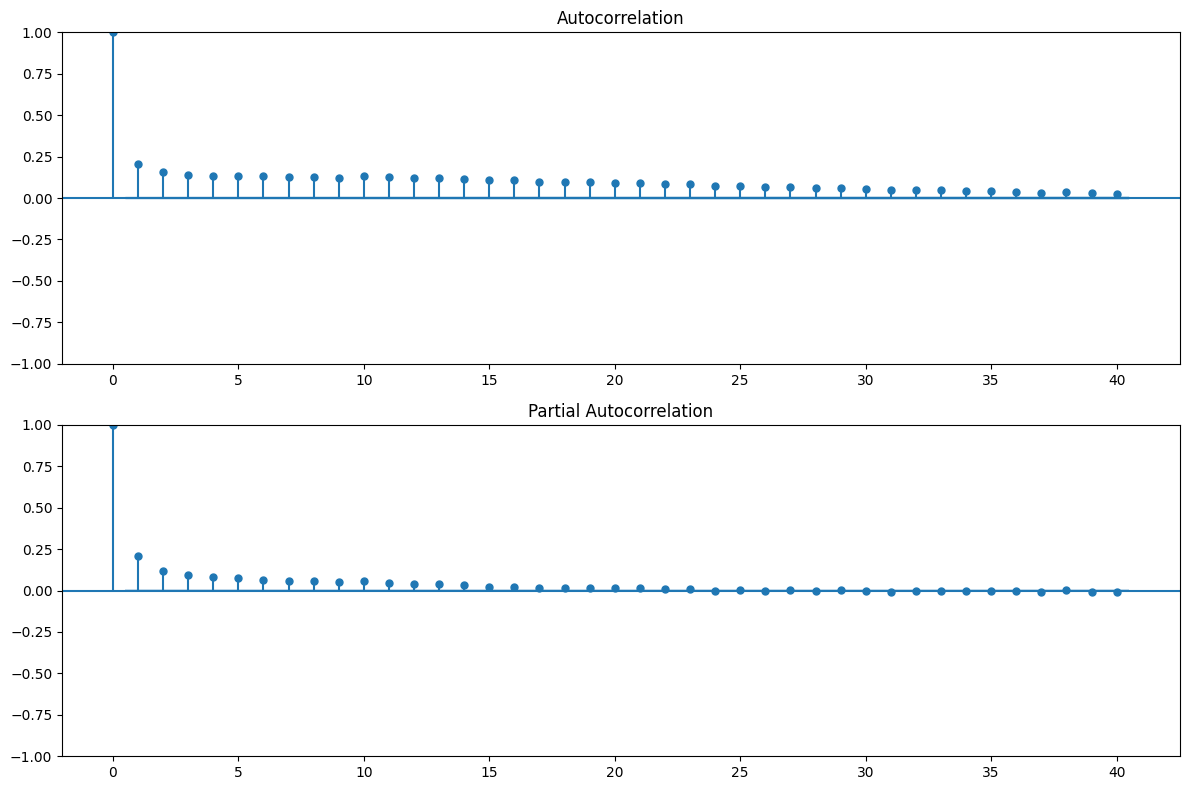

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(timeseries, lags=40):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(timeseries, lags=lags, ax=ax1)
    ax1.xaxis.set_ticks_position('bottom')
    fig.tight_layout();

    ax2 = fig.add_subplot(212)
    fig = plot_pacf(timeseries, lags=lags, ax=ax2)
    ax2.xaxis.set_ticks_position('bottom')
    fig.tight_layout();

    plt.show()


plot_acf_pacf(station_data['BIKE_USAGE'])
